In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from skimage.data import imread
import cv2
from sklearn.metrics import accuracy_score

import tensorflow as tf 
seed = 100

## 1. Import the data

Let's have a look at the file list first. See how they are saved. 

In [52]:
os.listdir('../input/flowers/flowers/daisy')[:5]

['2567033807_8e918c53d8_n.jpg',
 '5904946193_bd1eb1f39d_n.jpg',
 '8645839873_0151fb92bf_n.jpg',
 '21626652132_97e1318bb8_m.jpg',
 '5435521200_92029bbe2b_n.jpg']

In [53]:
path = '../input/flowers/flowers/'
flower_labels = os.listdir(path)
flower_labels

['tulip', 'rose', 'dandelion', 'sunflower', 'daisy']

We have five types of flowers: Tulip, Rose, Dandelion, Sunflower, and Daisy. We should convert them into one-hot-encodding later. Before that, checking the distributions of each category is also an important step. 

In [54]:
num_per_class = {}

for i in flower_labels:
    num_per_class[i] = len(os.listdir(path + i))

num_per_class

{'tulip': 984, 'rose': 784, 'dandelion': 1055, 'sunflower': 734, 'daisy': 769}

Now let's upload the data. As the images have different sizes, I'll transform the size into (64, 64, 3) with `cv2.resize()`. 

In [55]:
im_size = 64
n_class = len(num_per_class)

images = []
labels = []

for i in flower_labels:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path)
                 if i.endswith('.jpg')]
    for f in filenames:
        img = imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

## 2. Preprocessing

Why don;t we take a break and enjoy these beautiful flowers for a moment? :-)

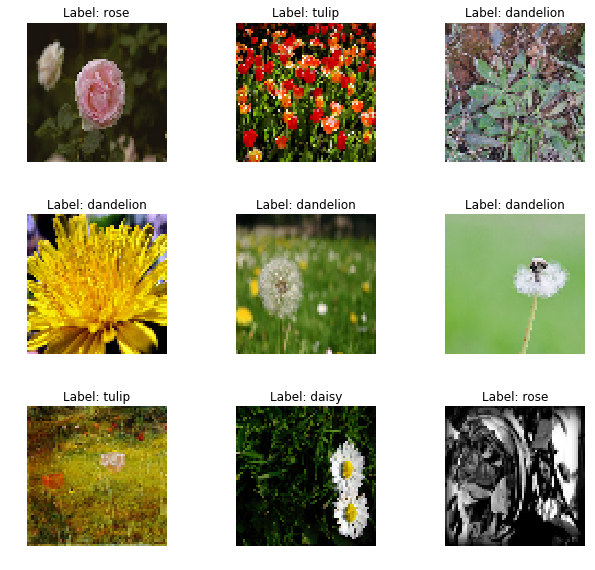

In [56]:
examples = np.random.randint(0, len(images), 9)
plt.figure(figsize = (10, 10))
i = 1

for ex in examples:
    img = images[ex]
    plt.subplot(3, 3, i)
    plt.subplots_adjust(wspace = 0.5)
    plt.axis('off')
    plt.title("Label: {}".format(labels[ex]))
    plt.imshow(img)
    i += 1

Now we're going to chance the images to numpy array. 

In [57]:
# Converting into numpy array 
images = np.array(images)

# Reducing the pixel values between 0 ~ 1
images = images.astype('float32') / 255.

Like I said above, we need to encode the labels for inputting the values into the model. This could be done easily with `get_dummies()` in pandas. 

In [58]:
# Label encodding
def one_hot(labels):
    labels = pd.DataFrame(labels)
    labels = pd.get_dummies(labels)
    return np.array(labels)

Before splitting the dataset into train and test set, we need to shuffle the images for getting ramdomness. It's important to shuffle the X values and y values together not losing their orderness. Therefore we'll reshape the data set and concatenate horizontally first. 

In [59]:
# Shuffle
def img_shuffle(images, labels_oh, frt = .1):
    a = im_size*im_size*3
    X_train = images.reshape((images.shape[0], a))
    X_y_train = np.hstack((X_train, labels_oh))
    
    np.random.shuffle(X_y_train)
    cut = int(len(X_y_train) * frt)
    
    X_val = X_y_train[:cut, :a]
    y_val = X_y_train[:cut, a:]
    X_train = X_y_train[cut:, :a]
    y_train = X_y_train[cut:, a:]
    
    X_train = X_train.reshape((X_train.shape[0], im_size, im_size, 3))
    X_val = X_val.reshape((X_val.shape[0], im_size, im_size, 3))
    
    return X_train, X_val, y_train, y_val

In [60]:
labels_oh = one_hot(labels)
X_train, X_val, y_train, y_val = img_shuffle(images, labels_oh)

print("The input shape of train set is {}".format(X_train.shape))
print("The input shape of validation set is {}".format(X_val.shape))
print("The output shape of train set is {}".format(y_train.shape))
print("The output shape of validation set is {}".format(y_val.shape))

The input shape of train set is (3891, 64, 64, 3)
The input shape of validation set is (432, 64, 64, 3)
The output shape of train set is (3891, 5)
The output shape of validation set is (432, 5)


## 2. Modeling

When implementing tensorflow, it's essential to understand how the values are computed. The key point here is 'lazy computing.' In tensorflow, we make a placeholder (which is the place for putting a variables later. think it as preparing an empty plate for putting food later) and draw a graph (which indicates the computations and relations between the variables. think this as a map that variables are going to follow). 

In [61]:
# Initialize placeholders 
X = tf.placeholder(tf.float32, [None, im_size, im_size, 3])
y = tf.placeholder(tf.float32, [None, n_class])

print("X = ", X)
print("y = ", y)

X =  Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
y =  Tensor("Placeholder_3:0", shape=(?, 5), dtype=float32)


Again, these values are empty, meaning no values in there. But it has premade seats where we'll but the values. Having `None` in the shape allows us to input whatever number of samples on it. We can put 1000, 2000 or 140,103 observations. 

Now let's build ConvNets.  These are the same with what we do with Keras. 

In [64]:
# ConvNet_1
Z1 = tf.layers.conv2d(X, filters = 32, kernel_size = 7, strides = [2, 2], padding = 'VALID')
A1 = tf.nn.relu(Z1)
P1 = tf.nn.max_pool(A1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

# ConvNet_2
Z2 = tf.layers.conv2d(P1, filters = 64, kernel_size = 3, strides = [1, 1], padding = 'VALID')
A2 = tf.nn.relu(Z2)
P2 = tf.nn.max_pool(A2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

# Flattening 
P2 = tf.contrib.layers.flatten(P2)

# Fully-connected
Z3 = tf.contrib.layers.fully_connected(P2, n_class, activation_fn = None)

In [66]:
# Cost function 
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = y))

In [102]:
# Backpropagation with adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Let's implement mini-batch gradient descent. First, we'll shuffle the dataset again (but with a slightly different way this time). 
Second step is splitting the data into the same size of batches. 

In [111]:
learning_rate = .01
epochs = 100
batch_size = 64

def create_batch(X_train, y_train, batch_size):
    m = X_train.shape[0]
    
    # Shuffling
    NUM = list(np.random.permutation(m))
    X_shuffled = X_train[NUM, :]
    y_shuffled = y_train[NUM, :]
    
    # Number of batches
    n_batch = int(m/batch_size)
    batches = []
    
    # Splitting the data  
    for i in range(0, n_batch):
        X_batch = X_shuffled[i*batch_size:(i+1)*batch_size, :, :, :]
        y_batch = y_shuffled[i*batch_size:(i+1)*batch_size, :]

        batch = (X_batch, y_batch)
        batches.append(batch)
    
    # Handling the tail of the data 
    X_batch_end = X_shuffled[n_batch*batch_size+1:, :, :, :]
    y_batch_end = y_shuffled[n_batch*batch_size+1:, :]
    batch = (X_batch_end, y_batch_end)
    batches.append(batch)
    
    return batches

In [112]:
# Checking 
batches = create_batch(X_train, y_train, batch_size)
(X_batch, y_batch) = batches[0]
print(X_batch.shape)
print(y_batch.shape)

(64, 64, 64, 3)
(64, 5)


Cost after 0 epoch: 1.6857208569844566
Cost after 10 epoch: 0.7816890408595402
Cost after 20 epoch: 0.4258592146138352
Cost after 30 epoch: 0.2956401951611042
Cost after 40 epoch: 0.1478555413583914
Cost after 50 epoch: 0.1741888280026614
Cost after 60 epoch: 0.6325964137911796
Cost after 70 epoch: 0.08063668911345302
Cost after 80 epoch: 0.3311502479637662
Cost after 90 epoch: 0.08185672778248165


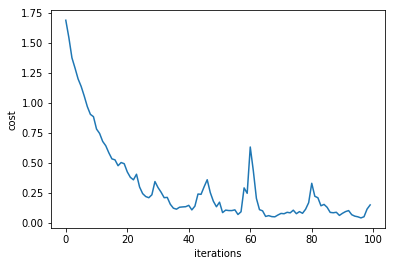

In [113]:
costs = []

# Initialization all the variables globally
init = tf.global_variables_initializer()

# Run the session and compute
with tf.Session() as sess:
    
    sess.run(init)
    
    for epoch in range(epochs):

        # mini-batch gradient descents
        batches = create_batch(X_train, y_train, batch_size)
        batch_cost = 0
        n_batch = int(m/batch_size)
        
        for batch in batches:
            
            (X_batch, y_batch) = batch           
            _, temp_cost = sess.run([optimizer, loss], feed_dict = {X : X_batch, y : y_batch})
            batch_cost += temp_cost/n_batch

        # Print the cost per each epoch
        if epoch % 10 == 0:
            print("Cost after {0} epoch: {1}".format(epoch, batch_cost))
        if epoch % 1 == 0:
            costs.append(batch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.show()

    pred_op = tf.argmax(Z3, 1)
    actual = tf.argmax(y_train, 1)
    correct_pred = tf.equal(pred_op, actual)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, 'float'))

Reference : [The course material from deep learning specialization by Andrew Ng](https://github.com/jjone36/Coursera_deeplearning_ai/blob/master/course_4_Convolutional%20Neural%20Networks/2.%20Convolution%20model-Application-v1.ipynb) 